<a href="https://colab.research.google.com/github/yossilevii100/critical_points2/blob/master/from_Critical_Points_to_Critical_Points%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Critical Points to Critical Points++ Tutorial

This is a basic tutorial on *Critical Points*, as suggested in PointNet, and with our extension dubbed *Critical Points++*. It is a very basic and explanatory tutorial, even for a researches which are new to this topic.
First, let's run some boiler-plate code, to use it afterwards.


In [1]:
! git clone https://github.com/yossilevii100/critical_points2.git
%cd critical_points2

Cloning into 'critical_points2'...
remote: Enumerating objects: 315, done.
remote: Counting objects: 100% (315/315), done.
remote: Compressing objects: 100% (253/253), done.
remote: Total 315 (delta 45), reused 308 (delta 41), pack-reused 0
Receiving objects: 100% (315/315), 4.18 MiB | 18.87 MiB/s, done.
Resolving deltas: 100% (45/45), done.
/content/critical_points2


In [ ]:
! pip install pointnet2_ops_lib/.

Processing ./pointnet2_ops_lib
  Preparing metadata (setup.py) ... done
  Created wheel for pointnet2-ops: filename=pointnet2_ops-3.0.0-cp310-cp310-linux_x86_64.whl size=8705877 sha256=84aeef993bcd8cc6b30f1ec3986f6f7e0c55dc6f4cd51fa87f7459f866967646
  Stored in directory: /tmp/pip-ephem-wheel-cache-1zkb7ckv/wheels/0d/fc/f3/0cb1c247fe6701512aa40f725e5b596889deb8acc2945a9c46
Successfully built pointnet2-ops


In [19]:
! gdown https://drive.google.com/uc?id=1xTeDtc9SUyrCodhEhP5K3TOTy3Ons_AO

Downloading...
From: https://drive.google.com/uc?id=1xTeDtc9SUyrCodhEhP5K3TOTy3Ons_AO
To: /content/critical_points2/robust_classification_checkpoint.zip
100% 20.5M/20.5M [00:00<00:00, 75.2MB/s]


In [20]:
!unzip robust_classification_checkpoint.zip -d pretrained

Archive:  robust_classification_checkpoint.zip
   creating: pretrained/robust_classification_checkpoint/
  inflating: pretrained/robust_classification_checkpoint/dgcnn_critical_256_1024.t7  
  inflating: pretrained/robust_classification_checkpoint/gdanet_critical_256_1024.t7  
  inflating: pretrained/robust_classification_checkpoint/rpc_critical_256_1024.t7  


In [21]:
!mv pretrained/robust_classification_checkpoint/*.* robust_classification/pretrained


Let's download ModelNet-C. To use corrupted point-clouds

In [2]:
%cd data
! gdown https://drive.google.com/uc?id=1KE6MmXMtfu_mgxg4qLPdEwVD5As8B0rm
! unzip modelnet_c.zip
%cd ..

/content/critical_points2/data
Downloading...
From: https://drive.google.com/uc?id=1KE6MmXMtfu_mgxg4qLPdEwVD5As8B0rm
To: /content/critical_points2/data/modelnet_c.zip
100% 1.21G/1.21G [00:11<00:00, 104MB/s]
Archive:  modelnet_c.zip
   creating: modelnet_c/
  inflating: modelnet_c/jitter_2.h5  
  inflating: modelnet_c/add_global_2.h5  
  inflating: modelnet_c/rotate_1.h5  
  inflating: modelnet_c/clean.h5     
  inflating: modelnet_c/rotate_0.h5  
  inflating: modelnet_c/.DS_Store    
  inflating: modelnet_c/jitter_3.h5  
  inflating: modelnet_c/rotate_4.h5  
  inflating: modelnet_c/add_global_3.h5  
  inflating: modelnet_c/dropout_local_1.h5  
  inflating: modelnet_c/scale_4.h5   
  inflating: modelnet_c/dropout_global_1.h5  
  inflating: modelnet_c/add_local_1.h5  
  inflating: modelnet_c/scale_0.h5   
  inflating: modelnet_c/dropout_global_0.h5  
  inflating: modelnet_c/add_local_0.h5  
  inflating: modelnet_c/dropout_local_4.h5  
  inflating: modelnet_c/scale_1.h5   
  inflating: mo

#Critical Points

Now, let's first understand what critical points are.
In general, we can divide point-cloud classification network into 2 parts: *Featurizer* and *Classifier*. The *Featurizer* learns a per point feature for each input point. Then, a symmetric function is applied to aggregate the per-point features into a general vector representing the entire shape. And then, the *Classifier* is take the general vector as input and digest it to a vector of size $C$ (number of classes). In which the strongest entry represent the true labeled class.

Let's denote a point-cloud, $X \in N\times3$, where $N$ is number of input points. The Featurizer is transform this to a matrix denoted as $X_f \in N\times F$, Which $F$ is the feature size, typically selected as 1024.
Now, lets analyze $X_f$ by plot it using DGCNN.



In [25]:
%cd robust_classification

/content/critical_points2/robust_classification


<ipython-input-106-5851e0410ffd>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', 256)
<ipython-input-106-5851e0410ffd>:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(point[0],   # x


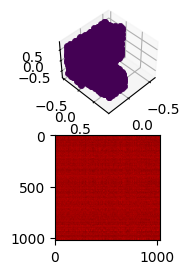

In [106]:
from models.dgcnn.model_dgcnn import DGCNN
import argparse
import torch
from torch.utils.data import DataLoader
from modelnetc_utils import eval_corrupt_wrapper, ModelNetC
from utils.util import extract_discrete_critical
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_pc(pc, importance, ax):
    # pc: 1x3xN
    # importance: 1,N
    # normalize the importance
    from matplotlib import cm
    cmap = cm.get_cmap('viridis', 256)
    importance = importance/(torch.max(importance)+1e-9)
    pc = pc[0,:].transpose(0,1)
    for ii, point in enumerate(pc):
        # point: 3,
        point = point.detach().cpu().numpy()
        mcolor = int(importance[0,ii]*255)
        ax.scatter(point[0],   # x
                  point[1],   # y
                  point[2],   # z
                  c=cmap.colors[mcolor,:],
                  marker="o",
                  linewidth=0.5)


split = "clean" # can select from [dropout_global_0..., dropout_local_0..., add_global_0..., add_local_0...]
# init args
class m_args():
    def __init__(self, k, emb_dims, dropout, cuda, test_batch_size):
        self.k = k
        self.emb_dims = emb_dims
        self.dropout = dropout
        self.cuda = cuda
        self.test_batch_size = test_batch_size
args = m_args(k=20, emb_dims=1024, dropout=0.3, cuda=torch.cuda.is_available(), test_batch_size=4)

# load model
device = torch.device("cuda" if args.cuda else "cpu")
model = DGCNN(args).to(device)
critical_path = os.path.join('pretrained', 'dgcnn_critical_256_1024.t7')
checkpoint = torch.load(critical_path, map_location='cpu')
model.load_state_dict(checkpoint)

test_loader = DataLoader(ModelNetC(args=args, split=split),
                                             batch_size=args.test_batch_size, shuffle=False, drop_last=False)

for m_iter, (data, label) in enumerate(test_loader):
    data, label = data.to(device), label.to(device).squeeze()
    data = data.permute(0, 2, 1)
    logits, x_f = model(data) #BxFxN
    break

fig = plt.figure(figsize=(12,3))
for cur_b in range(x_f.shape[0]):
  ax0 = fig.add_subplot(2, 4, cur_b+1, projection='3d')
  ax0.view_init(45, 45)
  visualize_pc(data[[cur_b],:], torch.zeros((1, data.shape[-1])), ax0)
  ax0 = fig.add_subplot(2, 4, cur_b+1+4)
  x_f_np = x_f[cur_b,:].detach().cpu().numpy()
  ax0.imshow(x_f_np)
  break




$X_f$ is comprises of $N$ points (first dimension), each point is featurized to a vector with size $F$ (second dimension). Looking on this matrix is not yields relevant information. We need to find a method to understand the impact of each point.

As I mentioned earlier, to compress this per-point features into a global feature, the common practice is to use MaxPool (holds symmetric, thus, permutation invariant), means that for each feature we take the maximal value among all points. In this sense, only the maximal feature is contributing to the global feature vector. Therefore, only a subset of points is actually contribute to the classification. These points are the points that at least one of the it's features is the maximal one. This subset is denoted as *Critical Set* or a *Critical Points*.

To better understand it, let's plot the critical points of some clouds.

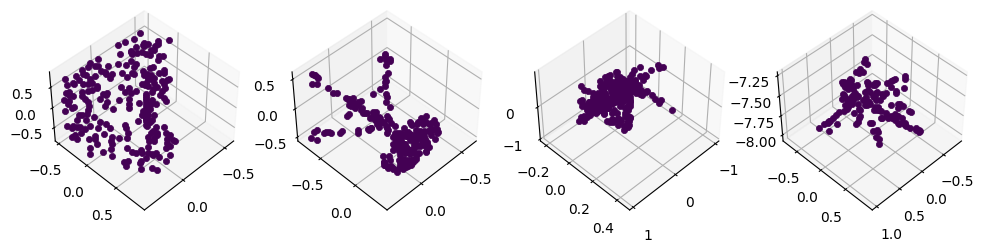

In [91]:
def critical_points(x_f, x):
    # x_f: FxN
    # x: 3XN
    critical_indices = torch.max(x_f, dim=0)[1] # N
    inds = torch.unique(critical_indices).reshape(1,-1)
    inds = inds.repeat(3,1).to(torch.int64)
    m_critical_points = torch.gather(x, index=inds, dim=-1)
    return m_critical_points

fig = plt.figure(figsize=(12,3))
for cur_b in range(x_f.shape[0]):
    m_critical_points = critical_points(x_f[cur_b,:], data[cur_b,:])
    ax0 = fig.add_subplot(1, 4, cur_b+1, projection='3d')
    ax0.view_init(45, 45)
    visualize_pc(m_critical_points.unsqueeze(0), torch.zeros(1,m_critical_points.shape[-1]), ax0)
    break


As can be seen, the critical points are discriptive and span the skeleton of the shape.

But this definition is binary. Each point is either part of the critical set, or not. Moreover, all the points in the critical set are have the same impact, however we can rank them in more delicate way (still discrete).

# Critical Points ++

## Decrete Measure

Now, we understand more what $X_f$ is, and how does it affect global feature vector. Moreover, we better understand how to extract the *critical points* out of it.
Now, we want to elaborate on how we can rank the critical points by their impact. This we term as *Critical Points++*.

The basic idea is simple, we want to count per-point the number of features determined in the global feature by this point.
For example, if point number 17 has the maximal feature in entries: 13, 302 and 761. We will set to point number 17 the value 3. Because this point is determine the global feature value in 3 different feature entries.
This simple process will describe each point with a discrete number in the range of $[0 ... F]$, such that this importance measurement is sum-up to $F$ for each cloud.

Let's look at this in the code, and plot the point-cloud color-coded by this importance measure.

<ipython-input-106-5851e0410ffd>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', 256)
<ipython-input-106-5851e0410ffd>:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(point[0],   # x


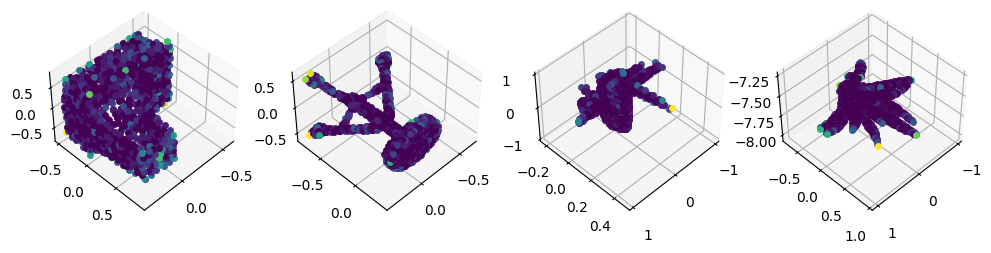

In [107]:
from utils.util import extract_discrete_critical

fig = plt.figure(figsize=(12,3))
for cur_b in range(x_f.shape[0]):
    ax0 = fig.add_subplot(1, 4, cur_b+1, projection='3d')
    ax0.view_init(45, 45)
    critical_ppc, discrete_importance = extract_discrete_critical(data[[cur_b],:], model)
    visualize_pc(data[[cur_b],:], discrete_importance, ax0)

Now we can see that points are ranked differently depend on their impact on the aggregated global feature. The prominent points, that are closed to edges and high curvatures are marked with more importance than others. Nevertheless, there are three main insights to pay attention for:
1. *Critical Points* are the points that their *Discrete Measure* is larger than 0. Therefore, critical points are contained in our definition ($CP == CP++>0$)
2. The visualization of the discrete measure is contains the usefull information but do not look nice since it is discrete and not smooth.
3. The discrete measure is missing information regarding strong features that "hided" after stronger features. In other words, a point can be with 0 in the discrete measure although it has strong features, just because there exist other points that their exact same feature is stronger. You can think of example of 2 distant points that one is farther than the other. Although both are prominent, it is possible that one of them will "win" the other in all features. Thus, the discrete measure of the closer point can be 0 although it is arguably prominent as the other.

Therefore, we suggest a smooth Importance Measure, that is more suitable for EXplainable AI (XAI), and for outlier removal.


## Soft Measure

In this measure we take into account all the features, regardless of them being the most prominent among all points. For this we just need to sum-up the contribution from the entire per-point feature. The calculation is simply: $I_{Soft} = ∑_{i=1}^{N} |X_f(i)|$.
Lets look at the same clouds with their soft measure..

<ipython-input-106-5851e0410ffd>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', 256)
<ipython-input-106-5851e0410ffd>:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(point[0],   # x


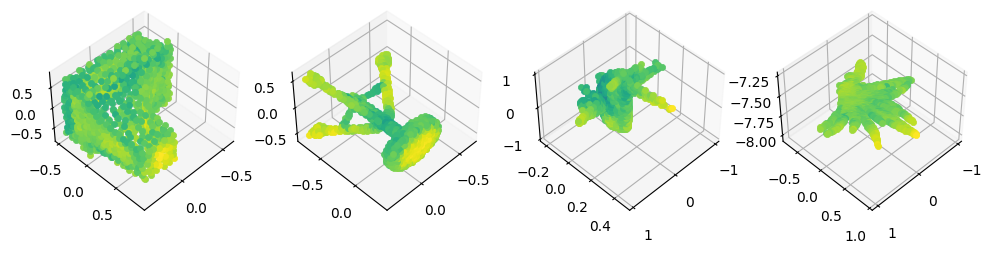

In [108]:
from utils.util import extract_soft_critical

fig = plt.figure(figsize=(12,3))
for cur_b in range(x_f.shape[0]):
    ax0 = fig.add_subplot(1, 4, cur_b+1, projection='3d')
    ax0.view_init(45, 45)
    soft_importance = extract_soft_critical(data[[cur_b],:], model)
    visualize_pc(data[[cur_b],:], soft_importance, ax0)

As can be seen, the importance is much more smooth, and represent the contribution of each of the points to the classification. This measurement is more suitable for visualization and XAI, and in general when the object to investigate is the point-cloud itself, and not the classification. We actually using the classification network (in this case, DGCNN) to understand better the point-cloud itself instead of the classic purpose of classification network - to use the input in order to reproduce classification.